In [1]:
!pip uninstall -y torch torchtext torchaudio --quiet

In [2]:
pip install torch==2.0.0+cu118 torchtext==0.15.0 --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 GB 667.4 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 41.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.3/63.3 MB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 35.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.3/132.3 kB 6.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lit: filename=lit-15.0.7-py3-none-any.whl size=89991 sha256=27323ae0544526258c4bd6d996a2cc2177a4ac4fb1034c4f59484d5b15d1e62c
  Stored in directory: /root/.cache/pip/wheels/27/2c/b6/3ed2983b1b44fe0dea1bb35234b09f2c22fb8ebb308679c922
Successfully built lit
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.20.1+cu121 requires torch==2.5.1, bu

In [3]:
import torch
import torchtext
print(torch.__version__)
print(torchtext.__version__)

2.0.0+cu118
0.15.0+cpu


In [3]:
import torchtext.transforms as T

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import os
import re
import io
# import portalocker
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
import torch.nn.functional as F

from torchtext.datasets import AG_NEWS, IMDB
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
import torchtext.transforms as T
from torchtext.data.functional import sentencepiece_tokenizer, load_sp_model

from tqdm.notebook import trange, tqdm

import numpy as np
import os, pathlib, shutil, random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.utils import text_dataset_from_directory
import torch
from torch.utils.data import DataLoader, TensorDataset

In [4]:
learning_rate = 1e-4
nepochs = 50
batch_size = 128
max_len = 128

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import shutil
import os
import pandas as pd

zip_file_name = '/content/drive/MyDrive/Deep Learning/IMDB Dataset.csv'
shutil.copy(zip_file_name, '/content/')

'/content/IMDB Dataset.csv'

In [7]:
import os,pandas as pd,pathlib,shutil,random
df=pd.read_csv("/content/IMDB Dataset.csv")
df_train=df[:35000]
df_test=df[35000:]
base_dir=pathlib.Path("aclImdb")
train_dir=base_dir/"train"
test_dir=base_dir/"test"
val_dir=base_dir/"val"
for split_dir in [train_dir,test_dir,val_dir]:
    for category in ("neg","pos"):
        os.makedirs(split_dir/category,exist_ok=True)
def save_files(df,split_dir):
    for i,row in df.iterrows():
        label="pos"if row['sentiment']=="positive"else"neg"
        fname=f"{i}.txt"
        with open(split_dir/label/fname,"w")as f:
            f.write(row['review'])
save_files(df_train,train_dir)
save_files(df_test,test_dir)
for category in ("neg","pos"):
    files=os.listdir(train_dir/category)
    random.Random(1337).shuffle(files)
    num_val_samples=int(0.2*len(files))
    val_files=files[:num_val_samples]
    for fname in val_files:
        shutil.move(train_dir/category/fname,val_dir/category/fname)
print("Data split into train, test, and validation sets.")


Data split into train, test, and validation sets.


In [ ]:
batch_size = 32
train_ds = text_dataset_from_directory(
    "aclImdb/train", batch_size=batch_size)
val_ds = text_dataset_from_directory(
    "aclImdb/val", batch_size=batch_size)
test_ds = text_dataset_from_directory(
    "aclImdb/test", batch_size=batch_size)
text_only_train_ds = train_ds.map(lambda x, y: x)

Found 28000 files belonging to 2 classes.
Found 7000 files belonging to 2 classes.
Found 15000 files belonging to 2 classes.


In [8]:
import os
from torch.utils.data import Dataset, DataLoader
class IMDBDataset(Dataset):
    def __init__(self,data_dir):
        self.data=[]
        self.labels={"pos":1,"neg":0}
        for label,label_id in self.labels.items():
            folder_path=os.path.join(data_dir,label)
            for filename in os.listdir(folder_path):
                file_path=os.path.join(folder_path,filename)
                with open(file_path,"r",encoding="utf-8")as f:
                    text=f.read().strip()
                    self.data.append((text,label_id))
    def __len__(self):
        return len(self.data)
    def __getitem__(self,idx):
        return self.data[idx]

data_dir="/content/aclImdb/train"
train_dataset=IMDBDataset(data_dir)
batch_size=32
train_loader=DataLoader(train_dataset,batch_size=batch_size,shuffle=True,num_workers=2)
for batch_texts,batch_labels in train_loader:
    print("Batch Texts:",batch_texts[:2])
    print("Batch Labels:",batch_labels[:2])
    break


Batch Texts: ('One thing I always liked about Robert Ludlum thrillers is just when you think you have it figured out, it goes in a completely different direction. There are so many twists and turns in this film that I have a sore neck from watching.<br /><br />One thing I also like about director John Dahl (Kill Me Again, Rounders, Unforgettable) is that he can be depended upon to direct and, in this case, write (with his brother Rick) a good story.<br /><br />Now, add Nick Cage, Dennis Hopper, Lara Flynn Boyle, and J.T. Walsh to the cast and you have a story that will keep your interest even if they are playing characters that all of them have perfected. Dahl seems to bring out the best in folks, and this will keep you interested, and guessing, until the very end.', 'As a lover of bad movies, I definitely hit paydirt with this one. The plot isn\'t really that bad, but there are a few instances where you really have to ask yourself "what the heck is going on here?"<br /><br />There are

In [9]:
data_dir="/content/aclImdb/val"

val_dataset = IMDBDataset(data_dir)
batch_size = 32
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True,num_workers=2)

for batch_texts, batch_labels in val_loader:
    print("Batch Texts:", batch_texts[:2])
    print("Batch Labels:", batch_labels[:2])
    break


Batch Texts: ('I finally got my wish to see this one in a cinema. I\'d seen Fritz Lang\'s film on video some years ago. I\'d been hoping that ideal screening conditions would work their magic.<br /><br />Conditions were ideal at Cinematheque Ontario. Pristine full-length print. Intertitles in the original Gothic-script German with simultaneous English translation, accurate without being too literal. Live piano accompaniment. Ideal.<br /><br />The film\'s magic sputtered for a little while but ultimately failed to catch, at least for me.<br /><br />This film bears no real relation to Wagner\'s Ring cycle as I already knew but some may not. Wagner had adapted the 13th c. Niebelungenlied to his own purposes. Part I of Fritz Lang\'s epic -- "Siegfried" -- has much that will be familiar to listeners of Wagner however.<br /><br />"Kriemhild\'s Revenge" is the story of Siegfried\'s wife Kriemhild, her marriage to King Etzel (Attila) the Hun, and her desire for revenge against Hagen and Gunthe

## Data processing and Tokenization

In [10]:
import os,pandas as pd
from torchtext.data.functional import generate_sp_model
data_path="/content/IMDB Dataset.csv"
output_text_file="/content/data.txt"
df=pd.read_csv(data_path)
with open(output_text_file,"w")as f:
    for review in df['review']:
        f.write(review.strip()+"\n")
generate_sp_model(output_text_file,vocab_size=20000,model_prefix='spm_imdb_news')

In [11]:
import torchtext.transforms as T
tokenizer=T.SentencePieceTokenizer("spm_imdb_news.model")
batch_texts,batch_labels=next(iter(train_loader))
print("Original Texts:")
for i,text in enumerate(batch_texts[:2]):
    print(f"{i+1}:{text}")
print("\nTokenized Texts:")
for i,text in enumerate(batch_texts[:2]):
    tokens=tokenizer(text)
    print(f"{i+1}:{tokens}")

Original Texts:
1:I don't even know where to start. I did not like it. It did not behave like a story and so much was injected into the movie (the pot brownies, the son was gay (?) the murder was justified, what possible reason could there be in the script for Linda aka Penelope to exist) that was never explained. It was all fluid spilled on a table and left dripping off the counter until it all made a big mess on the floor.<br /><br />Why did Vanessa Redgrave make a five second cameo? Why did Diane Wiest use her Bullets over Broadway character without the camp-fun? Why was Jane Birkin in the storyline to begin with. The list is endless. The movie ended and we all looked at each other -- like -- did you understand any of this??<br /><br />I tell ya one thing, if I watched my long lost Dad get murdered I certainly wouldn't be hugging the murderer. Tell ya another thing, if "Bob" broke up with "Bob" what purpose did hiding the son in the closet have? Was Bob going to have sex with Bob in

In [12]:
def yield_tokens(file_path):
    with io.open(file_path,encoding='utf-8')as f:
        for line in f:
            yield[line.split("\t")[0]]
vocab=build_vocab_from_iterator(yield_tokens("spm_imdb_news.vocab"),specials=['<pad>','<sos>','<eos>','<unk>'],special_first=True)
vocab.set_default_index(vocab['<unk>'])

In [ ]:
vocab.get_itos()

['<pad>',
 '<sos>',
 '<eos>',
 '<unk>',
 '!',
 '!!',
 '!!!',
 '!!!!',
 '!!!!!',
 '!!!!!!',
 '!!!!!!!!!',
 '!!!!!!!!!!!!!!!!',
 '!!)',
 '!"',
 '!")',
 '!)',
 '!),',
 '!).',
 '!).<',
 '!<',
 '"',
 '"!',
 '")',
 '"),',
 '").',
 '",',
 '".',
 '"...',
 '";',
 '"?',
 '&',
 "'",
 '(',
 '(!)',
 '(..',
 '(?)',
 ')',
 '),',
 ').',
 ')...',
 ').<',
 '):',
 ');',
 '*',
 '**',
 '***',
 '****',
 '*****',
 '******',
 '*********',
 '***************',
 '*1/2',
 ',',
 ',000,000',
 '-',
 '--',
 '---',
 '-----',
 '------------',
 '----------------',
 '-1',
 '-10',
 '-13',
 '-19',
 '-80',
 '.',
 '."',
 '...',
 '..."',
 '...)',
 '....',
 '.....',
 '......',
 '.......',
 '........',
 '............',
 '................',
 '.<',
 '/',
 '/10',
 '0',
 '0,000',
 '0.00',
 '00',
 '000',
 '01',
 '02',
 '08',
 '1',
 '1)',
 '1,000',
 '1/2',
 '10',
 '10,000',
 '100',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '2',
 '20',
 '200',
 '22',
 '23',
 '24',
 '25',
 '28',
 '2:37',
 '3',
 '3.99',
 '30',
 '35

In [29]:
text_tranform=T.Sequential(
    T.SentencePieceTokenizer("spm_imdb_news.model"),
    T.VocabTransform(vocab=vocab),
    T.AddToken(1,begin=True),
    T.Truncate(max_seq_len=max_len),
    T.AddToken(2,begin=False),
    T.ToTensor(padding_value=0),
)

In [14]:
import torchtext.transforms as T

test_sentences = [
    "is an amazing movie!",
    "The plot was boring and predictable.",
    "I loved the characters and the story.",
    "Not worth watching, terrible acting."
]
max_len = 10
text_tranform = T.Sequential(
    T.SentencePieceTokenizer("spm_imdb_news.model"),  #Adjust this path to your model
    T.VocabTransform(vocab=vocab),
    T.AddToken(1, begin=True),  #Add <sos> token
    T.Truncate(max_seq_len=max_len),  #Truncate sentences longer than max_len
    T.AddToken(2, begin=False),  #Add <eos> token
    T.ToTensor(padding_value=0)  #Pad sentences with <pad> token
)
transformed_sentences = [text_tranform(sentence) for sentence in test_sentences]
for original, transformed in zip(test_sentences, transformed_sentences):
    print(f"Original: {original}")
    print(f"Transformed: {transformed.tolist()}")
    print()

Original: is an amazing movie!
Transformed: [1, 14577, 9931, 9904, 15485, 4, 2]

Original: The plot was boring and predictable.
Transformed: [1, 9038, 16321, 19705, 10585, 9941, 16473, 65, 2]

Original: I loved the characters and the story.
Transformed: [1, 6617, 15006, 18879, 10972, 9941, 18879, 18375, 65, 2]

Original: Not worth watching, terrible acting.
Transformed: [1, 7751, 19923, 19718, 52, 18850, 9695, 65, 2]



In [15]:
class TokenDrop(nn.Module):
    """For a batch of tokens indices, randomly replace a non-special token with <pad>.

    Args:
        prob (float): probability of dropping a token
        pad_token (int): index for the <pad> token
        num_special (int): Number of special tokens, assumed to be at the start of the vocab
    """

    def __init__(self,prob=0.1,pad_token=0,num_special=4):
        self.prob=prob
        self.num_special=num_special
        self.pad_token=pad_token
    def __call__(self,sample):
        mask=torch.bernoulli(self.prob*torch.ones_like(sample)).long()
        can_drop=(sample>=self.num_special).long()
        mask=mask*can_drop
        replace_with=(self.pad_token*torch.ones_like(sample)).long()
        sample_out=(1-mask)*sample+mask*replace_with
        return sample_out


In [24]:
class SinusoidalPosEmb(nn.Module):
    def __init__(self,dim):
        super().__init__()
        self.dim=dim
    def forward(self,x):
        device=x.device
        half_dim=self.dim//2
        emb=math.log(10000)/(half_dim-1)
        emb=torch.exp(torch.arange(half_dim,device=device)*-emb)
        emb=x[:,None]*emb[None,:]
        emb=torch.cat((emb.sin(),emb.cos()),dim=-1)
        return emb

class TransformerBlock(nn.Module):
    def __init__(self,hidden_size=128,num_heads=4):
        super().__init__()
        self.norm1=nn.LayerNorm(hidden_size)
        self.multihead_attn=nn.MultiheadAttention(hidden_size,num_heads=num_heads,batch_first=True,dropout=0.25)
        self.norm2=nn.LayerNorm(hidden_size)
        self.mlp=nn.Sequential(nn.Linear(hidden_size,hidden_size),nn.LayerNorm(hidden_size),nn.ELU(),nn.Linear(hidden_size,hidden_size))
    def forward(self,x,key_padding_mask,return_attn=False):
        norm_x=self.norm1(x)
        attn_output,attn_w=self.multihead_attn(norm_x,norm_x,norm_x,key_padding_mask=key_padding_mask)
        x=attn_output+x
        norm_x=self.norm2(x)
        mlp_output=self.mlp(norm_x)
        output=mlp_output+x
        if(return_attn):
          return output,attn_w
        return output

class Transformer(nn.Module):
    def __init__(self,num_emb,output_size,hidden_size=128,num_layers=3,num_heads=4):
        super(Transformer,self).__init__()
        self.embedding=nn.Embedding(num_emb,hidden_size)
        self.pos_emb=SinusoidalPosEmb(hidden_size)
        self.blocks=nn.ModuleList([TransformerBlock(hidden_size,num_heads)for _ in range(num_layers)])
        self.out_vec=nn.Parameter(torch.zeros(1,1,hidden_size))
        self.fc_out=nn.Linear(hidden_size,output_size)
    def forward(self,input_seq,return_attn=False):
        bs,_=input_seq.shape
        key_padding_mask=input_seq==0
        key_padding_mask=torch.cat((torch.zeros(bs,1,device=input_seq.device).bool(),key_padding_mask),1)
        input_embs=self.embedding(input_seq)
        input_embs=torch.cat((self.out_vec.expand(bs,1,-1),input_embs),1)
        bs,l,h=input_embs.shape
        seq_indx=torch.arange(l,device=input_seq.device)
        pos_emb=self.pos_emb(seq_indx).reshape(1,l,h).expand(bs,l,h)
        embs=input_embs+pos_emb
        attn_map=[]
        for block in self.blocks:
            embs,attn_weight=block(embs,key_padding_mask,return_attn=True)
            attn_map.append(attn_weight)
        if(return_attn):
          return self.fc_out(embs[:,0]),attn_map

        return self.fc_out(embs[:,0])


## Initialize Model and Optimizer

In [20]:
device=torch.device("cuda:0"if torch.cuda.is_available()else"cpu")
hidden_size=512
tf_classifier=Transformer(num_emb=len(vocab),output_size=2,hidden_size=hidden_size,num_layers=6,num_heads=8).to(device)
optimizer=optim.Adam(tf_classifier.parameters(),lr=learning_rate)
lr_scheduler=optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max=nepochs,eta_min=0)
loss_fn=nn.CrossEntropyLoss()
scaler=torch.cuda.amp.GradScaler()
td=TokenDrop(prob=0.5)
training_loss_logger=[]
test_loss_logger=[]
training_acc_logger=[]
test_acc_logger=[]


In [21]:
num_model_params = 0
for param in tf_classifier.parameters():
    num_model_params += param.flatten().shape[0]

print("-This Model Has %d (Approximately %d Million) Parameters!" % (num_model_params, num_model_params//1e6))

-This Model Has 19717122 (Approximately 19 Million) Parameters!


## Train Model

In [23]:
pbar=trange(0,nepochs,leave=False,desc="Epoch")
train_acc=0
test_acc=0
accumulation_steps=4
for epoch in pbar:
    train_acc_count=0
    test_acc_count=0
    pbar.set_postfix_str('Accuracy: Train %.2f%%, Test %.2f%%'%(train_acc*100,test_acc*100))
    tf_classifier.train()
    steps=0
    optimizer.zero_grad()
    for batch in tqdm(train_loader,desc="Training",leave=False):
        text,label=batch
        bs=len(label)
        text_tokens=text_tranform(list(text)).to(device)
        label=label.to(device)
        text_tokens=td(text_tokens)
        with torch.cuda.amp.autocast():
            pred=tf_classifier(text_tokens)
            loss=loss_fn(pred,label)
        loss=loss/accumulation_steps
        scaler.scale(loss).backward()
        training_loss_logger.append(loss.item())
        train_acc_count+=(pred.argmax(1)==label).sum().item()
        steps+=bs
        if(steps%accumulation_steps==0)or(steps==len(train_loader)-1):
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
    train_acc=train_acc_count/steps
    training_acc_logger.append(train_acc)
    lr_scheduler.step()
    tf_classifier.eval()
    steps=0
    with torch.no_grad():
        for batch in tqdm(val_loader,desc="Testing",leave=False):
            text,label=batch
            bs=len(label)
            text_tokens=text_tranform(list(text)).to(device)
            label=label.to(device)
            with torch.cuda.amp.autocast():
                pred=tf_classifier(text_tokens)
                loss=loss_fn(pred,label)
            test_loss_logger.append(loss.item())
            test_acc_count+=(pred.argmax(1)==label).sum().item()
            steps+=bs
        test_acc=test_acc_count/steps
        test_acc_logger.append(test_acc)
    if(epoch+1)%3==0:
        model_save_path=f"tf_classifier_epoch_{epoch+1}.pth"
        torch.save(tf_classifier.state_dict(),model_save_path)
        print(f"Model saved at epoch {epoch+1}")

Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/875 [00:00<?, ?it/s]

Testing:   0%|          | 0/219 [00:00<?, ?it/s]

Training:   0%|          | 0/875 [00:00<?, ?it/s]

Testing:   0%|          | 0/219 [00:00<?, ?it/s]

Training:   0%|          | 0/875 [00:00<?, ?it/s]

Testing:   0%|          | 0/219 [00:00<?, ?it/s]

Model saved at epoch 3


Training:   0%|          | 0/875 [00:00<?, ?it/s]

Testing:   0%|          | 0/219 [00:00<?, ?it/s]

Training:   0%|          | 0/875 [00:00<?, ?it/s]

Testing:   0%|          | 0/219 [00:00<?, ?it/s]

Training:   0%|          | 0/875 [00:00<?, ?it/s]

Testing:   0%|          | 0/219 [00:00<?, ?it/s]

Model saved at epoch 6


Training:   0%|          | 0/875 [00:00<?, ?it/s]

Testing:   0%|          | 0/219 [00:00<?, ?it/s]

Training:   0%|          | 0/875 [00:00<?, ?it/s]

Testing:   0%|          | 0/219 [00:00<?, ?it/s]

Training:   0%|          | 0/875 [00:00<?, ?it/s]

Testing:   0%|          | 0/219 [00:00<?, ?it/s]

Model saved at epoch 9


Training:   0%|          | 0/875 [00:00<?, ?it/s]

Testing:   0%|          | 0/219 [00:00<?, ?it/s]

Training:   0%|          | 0/875 [00:00<?, ?it/s]

Testing:   0%|          | 0/219 [00:00<?, ?it/s]

Training:   0%|          | 0/875 [00:00<?, ?it/s]

Testing:   0%|          | 0/219 [00:00<?, ?it/s]

Model saved at epoch 12


Training:   0%|          | 0/875 [00:00<?, ?it/s]

Testing:   0%|          | 0/219 [00:00<?, ?it/s]

Training:   0%|          | 0/875 [00:00<?, ?it/s]

Testing:   0%|          | 0/219 [00:00<?, ?it/s]

Training:   0%|          | 0/875 [00:00<?, ?it/s]

Testing:   0%|          | 0/219 [00:00<?, ?it/s]

Model saved at epoch 15


Training:   0%|          | 0/875 [00:00<?, ?it/s]

Testing:   0%|          | 0/219 [00:00<?, ?it/s]

Training:   0%|          | 0/875 [00:00<?, ?it/s]

Testing:   0%|          | 0/219 [00:00<?, ?it/s]

Training:   0%|          | 0/875 [00:00<?, ?it/s]

Testing:   0%|          | 0/219 [00:00<?, ?it/s]

Model saved at epoch 18


Training:   0%|          | 0/875 [00:00<?, ?it/s]

Testing:   0%|          | 0/219 [00:00<?, ?it/s]

Training:   0%|          | 0/875 [00:00<?, ?it/s]

Testing:   0%|          | 0/219 [00:00<?, ?it/s]

Training:   0%|          | 0/875 [00:00<?, ?it/s]

Testing:   0%|          | 0/219 [00:00<?, ?it/s]

Model saved at epoch 21


Training:   0%|          | 0/875 [00:00<?, ?it/s]

Testing:   0%|          | 0/219 [00:00<?, ?it/s]

Training:   0%|          | 0/875 [00:00<?, ?it/s]

Testing:   0%|          | 0/219 [00:00<?, ?it/s]

Training:   0%|          | 0/875 [00:00<?, ?it/s]

Testing:   0%|          | 0/219 [00:00<?, ?it/s]

Model saved at epoch 24


Training:   0%|          | 0/875 [00:00<?, ?it/s]

Testing:   0%|          | 0/219 [00:00<?, ?it/s]

Training:   0%|          | 0/875 [00:00<?, ?it/s]

Testing:   0%|          | 0/219 [00:00<?, ?it/s]

Training:   0%|          | 0/875 [00:00<?, ?it/s]

Testing:   0%|          | 0/219 [00:00<?, ?it/s]

Model saved at epoch 27


Training:   0%|          | 0/875 [00:00<?, ?it/s]

Testing:   0%|          | 0/219 [00:00<?, ?it/s]

Training:   0%|          | 0/875 [00:00<?, ?it/s]

Testing:   0%|          | 0/219 [00:00<?, ?it/s]

Training:   0%|          | 0/875 [00:00<?, ?it/s]

Testing:   0%|          | 0/219 [00:00<?, ?it/s]

Model saved at epoch 30


Training:   0%|          | 0/875 [00:00<?, ?it/s]

Testing:   0%|          | 0/219 [00:00<?, ?it/s]

Training:   0%|          | 0/875 [00:00<?, ?it/s]

Testing:   0%|          | 0/219 [00:00<?, ?it/s]

Training:   0%|          | 0/875 [00:00<?, ?it/s]

Testing:   0%|          | 0/219 [00:00<?, ?it/s]

Model saved at epoch 33


Training:   0%|          | 0/875 [00:00<?, ?it/s]

Testing:   0%|          | 0/219 [00:00<?, ?it/s]

Training:   0%|          | 0/875 [00:00<?, ?it/s]

Testing:   0%|          | 0/219 [00:00<?, ?it/s]

Training:   0%|          | 0/875 [00:00<?, ?it/s]

Testing:   0%|          | 0/219 [00:00<?, ?it/s]

Model saved at epoch 36


Training:   0%|          | 0/875 [00:00<?, ?it/s]

Testing:   0%|          | 0/219 [00:00<?, ?it/s]

Training:   0%|          | 0/875 [00:00<?, ?it/s]

Testing:   0%|          | 0/219 [00:00<?, ?it/s]

Training:   0%|          | 0/875 [00:00<?, ?it/s]

Testing:   0%|          | 0/219 [00:00<?, ?it/s]

Model saved at epoch 39


Training:   0%|          | 0/875 [00:00<?, ?it/s]

Testing:   0%|          | 0/219 [00:00<?, ?it/s]

Training:   0%|          | 0/875 [00:00<?, ?it/s]

Testing:   0%|          | 0/219 [00:00<?, ?it/s]

Training:   0%|          | 0/875 [00:00<?, ?it/s]

Testing:   0%|          | 0/219 [00:00<?, ?it/s]

Model saved at epoch 42


Training:   0%|          | 0/875 [00:00<?, ?it/s]

Testing:   0%|          | 0/219 [00:00<?, ?it/s]

Training:   0%|          | 0/875 [00:00<?, ?it/s]

Testing:   0%|          | 0/219 [00:00<?, ?it/s]

Training:   0%|          | 0/875 [00:00<?, ?it/s]

Testing:   0%|          | 0/219 [00:00<?, ?it/s]

Model saved at epoch 45


Training:   0%|          | 0/875 [00:00<?, ?it/s]

Testing:   0%|          | 0/219 [00:00<?, ?it/s]

Training:   0%|          | 0/875 [00:00<?, ?it/s]

Testing:   0%|          | 0/219 [00:00<?, ?it/s]

Training:   0%|          | 0/875 [00:00<?, ?it/s]

Testing:   0%|          | 0/219 [00:00<?, ?it/s]

Model saved at epoch 48


Training:   0%|          | 0/875 [00:00<?, ?it/s]

Testing:   0%|          | 0/219 [00:00<?, ?it/s]

Training:   0%|          | 0/875 [00:00<?, ?it/s]

Testing:   0%|          | 0/219 [00:00<?, ?it/s]

In [16]:
class IMDBDataset(Dataset):
    def __init__(self,data_dir):
        self.data=[]
        self.labels={"pos":1,"neg":0}
        for label,label_id in self.labels.items():
            folder_path=os.path.join(data_dir,label)
            for filename in os.listdir(folder_path):
                file_path=os.path.join(folder_path,filename)
                with open(file_path,"r",encoding="utf-8")as f:
                    text=f.read().strip()
                    self.data.append((text,label_id))
    def __len__(self):
        return len(self.data)
    def __getitem__(self,idx):
        return self.data[idx]

data_dir="/content/aclImdb/test"
test_dataset = IMDBDataset(data_dir)
batch_size = 32
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True,num_workers=2)
for batch_texts, batch_labels in test_loader:
    print("Batch Texts:", batch_texts[:2])
    print("Batch Labels:", batch_labels[:2])

Batch Texts: ("I have had more boring stretches of 80 minutes in my life, but none are coming to mind right now. Hell Ride is based on the retro cult 70s theme that Tarantino brought back, and did right, in movies like Pulp Fiction and Reservoir Dogs. The problem with Hell Ride is, unlike PF and RD, the story is garbage and so is character development. How many movies does Bishop think he can blatantly steal from? The brief case in Pulp Fiction, the air gun in No Country, etc. etc. Speaking of Bishop what the hell is he doing acting in this movie? I couldn't help but laugh at those scenes where he's standing with his pelvis trusted out, desperately trying to seem like some hardened biker. Nothing in this movie is believable. And why Dennis Hopper? Did they really need the Easy Rider motif too? I blame Larry Bishop, for his horrible plot and dialogue, not to mention his failed attempt at the leading role. Don't bother watching this movie, it's a waste of time.", "I have never commented 

In [17]:
test_examples = []
test_labels = []
model_prediction = []

for batch_texts,batch_labels in test_loader:
  test_examples.append(batch_texts)
  test_labels.append(batch_labels)
  break

print(f"Test Examples : {len(test_examples)}")

Test Examples : 1


In [41]:
import torch
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

test_examples,test_labels=[],[]
for batch_texts,batch_labels in test_loader:
    test_examples.extend(batch_texts)
    test_labels.extend(batch_labels)
    break

print(f"Number of Test Examples: {len(test_examples)}")

hidden_size=512
model=Transformer(num_emb=len(vocab),output_size=2,hidden_size=hidden_size,num_layers=6,num_heads=8).to(device)
state_dict=torch.load('/content/tf_classifier_epoch_48.pth',map_location=torch.device('cpu'))
model.load_state_dict(state_dict)
model.eval()

num=10
for i in range(num):
    input_text,label=test_examples[i],test_labels[i]
    print(f"\nTest Example {test_examples[i]}:")
    print(f"Label: {'Positive' if label==1 else 'Negative'}")
    text_tokens=text_tranform(input_text).to(device).unsqueeze(0)
    label=label.clone().detach().to(device)
    with torch.no_grad():
        output=model(text_tokens)
        prediction=output.argmax(dim=1).item()
    print("Prediction:","Positive" if prediction==1 else "Negative")

Number of Test Examples: 32

Test Example Before the release of George Romero's genre-defining Night of the Living Dead, zombies were relatively well-behaved creatures. They certainly had much better table-manners in the old days. But social etiquette aside what thrills did these early zombies offer to the movie-going public? Judging by this film, none whatsoever.<br /><br />The story is about an expedition to Cambodia, whose purpose is to find and destroy the secret of zombiefication. One of the party discovers the secrets on his own and sets about building his zombie army.<br /><br />This film is basically a love triangle with zombies. But seeing as this is a 30's movie, the said zombies are more like somnambulists than the flesh-eating variety we think of today. They seem to respond to mind-control, rather than insatiable appetites. And, quite frankly, the 'revolt' is somewhat underwhelming too. The whole thing is really very dull. Aside from the lack of horror, there isn't any over

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/activation.py:1144: UserWarning: Converting mask without torch.bool dtype to bool; this will negatively affect performance. Prefer to use a boolean mask directly. (Triggered internally at ../aten/src/ATen/native/transformers/attention.cpp:150.)
  return torch._native_multi_head_attention(


In [44]:
import pandas as pd

# Initialize the lists
test_examples, test_labels = [], []

# Loop through the test_loader
for batch_texts, batch_labels in test_loader:
    # Extend the test_examples with the batch_texts
    test_examples.extend(batch_texts)

    # Convert batch_labels from tensor to Python integers and extend the test_labels
    test_labels.extend(batch_labels.tolist())  # .tolist() converts tensor to a list
    # Only take the first batch, remove if you want all batches

# Check a sample of the data
print(test_labels[:5])  # This will show the first 5 labels as integers

# Convert to DataFrame
df = pd.DataFrame({
    'test_examples': test_examples,
    'test_labels': test_labels
})

# Save as CSV
csv_filename = "test_examples_labels.csv"
df.to_csv(csv_filename, index=False)

# Provide the download link
csv_filename

[0, 0, 0, 0, 1]


'test_examples_labels.csv'

In [40]:
test_examples[0]

'... And boy is it soft <br /><br />I saw this on cable channel Bravo one Saturday night and here in Britain we often have these dire " Erotic " soft core movies turning up late at night on Bravo . This one follows a WEIRD SCIENCE type plot of a couple of college geeks building a virtual reality headset that makes you have sexual fantasies . <br /><br />When you`ve seen one of these movies you`ve seen them all with a bunch of bimbos looking like they`re advertising silicone implants . Come on I`ve actually seen breasts in real life ( I`m sure some other of us have too ) and they wobble around unlike here where they defy the laws of , if not physics than at least gravity . The sex scenes are these tedious affairs where a well buffed geezer rubs himself against his co-star without any dialogue or sound apart from some muzak and when they climax it looks like they`re both having a bad attack of constipation . The girls themselves are very pretty especially Brandy Davis and Nikki Fritz but

#Attnetion VIZ

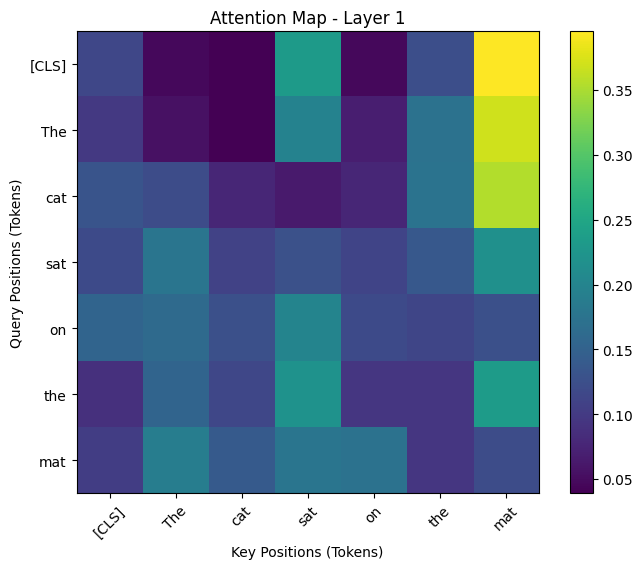

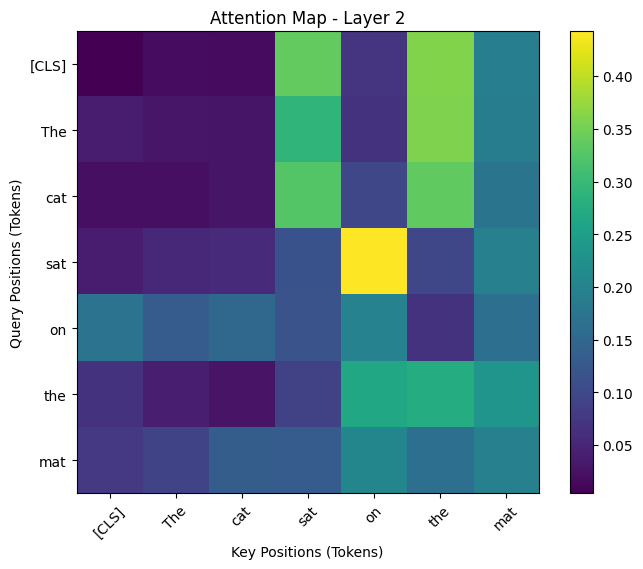

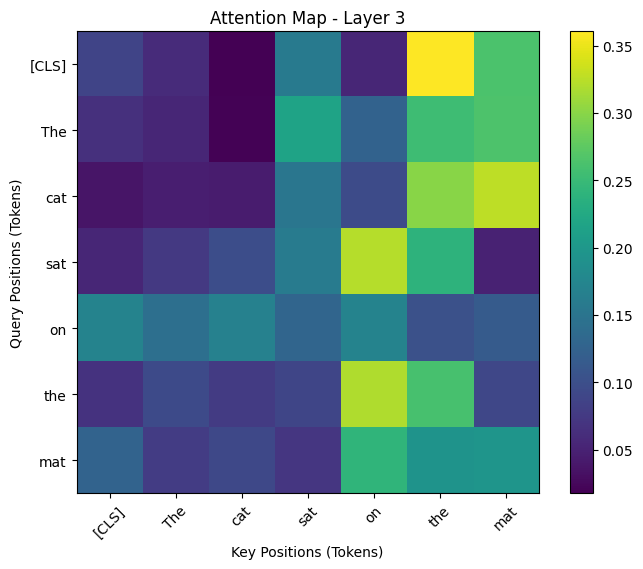

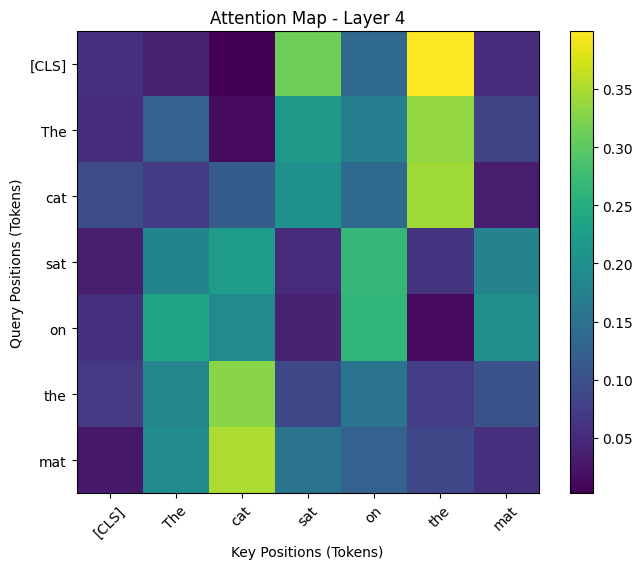

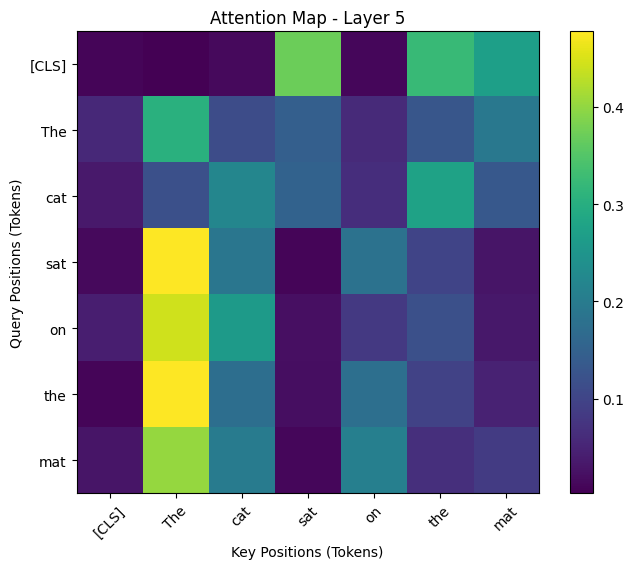

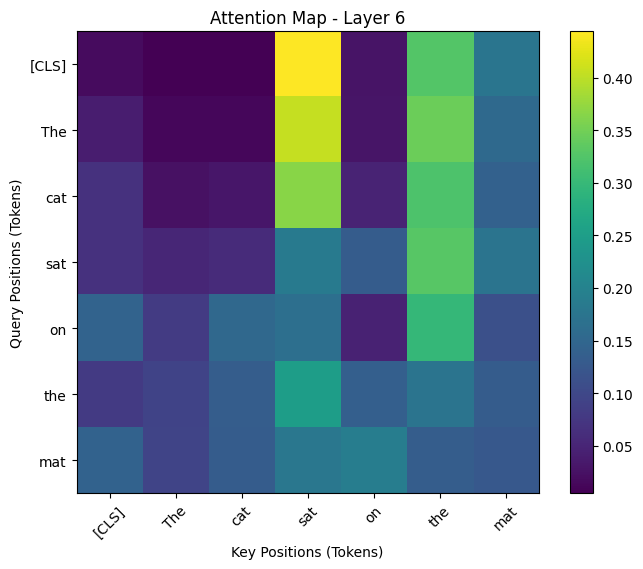

In [25]:
import torch
import matplotlib.pyplot as plt
from torch.nn import functional as F

# Simulating a vocabulary
vocab = {"<pad>": 0, "The": 1, "cat": 2, "sat": 3, "on": 4, "the": 5, "mat": 6, ".": 7}
sentence = "The cat sat on the mat"
tokens = sentence.split()  # Simple tokenization
input_indices = [vocab[token] for token in tokens]  # Convert to indices
input_seq = torch.tensor([input_indices])  # Add batch dimension

# Define the model
num_emb = len(vocab)
# model = Transformer(num_emb=num_emb, output_size=10, hidden_size=128, num_layers=3, num_heads=4)

# Forward pass with attention maps
output,attn_maps=tf_classifier(input_seq.to(device), return_attn=True)

# Plot attention maps for each layer
for layer_idx, attn_map in enumerate(attn_maps):
    plt.figure(figsize=(8, 6))
    plt.imshow(attn_map[0].detach().cpu().numpy(), cmap="viridis")
    plt.colorbar()
    plt.title(f"Attention Map - Layer {layer_idx + 1}")
    plt.xlabel("Key Positions (Tokens)")
    plt.ylabel("Query Positions (Tokens)")
    plt.xticks(range(len(tokens) + 1), ["[CLS]"] + tokens, rotation=45)
    plt.yticks(range(len(tokens) + 1), ["[CLS]"] + tokens)
    plt.show()


#Testing

In [6]:
!pip install textattack

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 50.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 47.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 445.7/445.7 kB 32.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 34.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.5/776.5 kB 52.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 769.7/769.7 kB 53.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.3/143.3 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━

In [8]:
import textattack
from transformers import BertTokenizer, BertForSequenceClassification

In [9]:
# Load Pre-trained BERT Model and Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased')

# Move the model to GPU if available
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [17]:
from textattack.models.wrappers import HuggingFaceModelWrapper
from transformers import BertTokenizer, BertForSequenceClassification
import torch
import textattack

# Load Pre-trained BERT Model and Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased')

# Move the model to GPU if available
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# Wrap the model with HuggingFaceModelWrapper for TextAttack
model_wrapper = HuggingFaceModelWrapper(model, tokenizer)

# Use TextAttack's TextFooler attack
attack = textattack.attack_recipes.TextFoolerJin2019.build(model_wrapper)

# Prepare the attack (can specify device if needed)
attack = attack.to(device)

# Example data for attack
example = "The movie was absolutely amazing!"
ground_truth_output = 1  # Assume the true label for the text is positive (1)

# Check if the attack is compatible with the model
if not attack.is_compatible_with(model_wrapper):
    print("Attack is not compatible with the model!")
else:
    # Run the attack to generate adversarial example
    adversarial_example = attack.attack(example, ground_truth_output)

    # Check if attack was successful
    if isinstance(adversarial_example, textattack.attack_results.SkippedAttackResult):
        print("Attack skipped. Try a different attack or model.")
    else:
        print("Original Text:", example)
        print("Adversarial Text:", adversarial_example.perturbed_text)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


AttributeError: 'Attack' object has no attribute 'to'

In [ ]:
from torch.utils.data import Dataset, DataLoader
import os

# Example: Define your dataset (Assuming IMDB dataset)
class IMDBDataset(Dataset):
    def __init__(self, data_dir):
        self.data = []
        self.labels = {"pos": 1, "neg": 0}
        for label, label_id in self.labels.items():
            folder_path = os.path.join(data_dir, label)
            for filename in os.listdir(folder_path):
                file_path = os.path.join(folder_path, filename)
                with open(file_path, "r", encoding="utf-8") as f:
                    text = f.read().strip()
                    self.data.append((text, label_id))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

data_dir = "/content/aclImdb/test"  # Change the path accordingly
test_dataset = IMDBDataset(data_dir)
batch_size = 32
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=2)


In [14]:
# Generate adversarial examples using TextAttack
for batch_texts, batch_labels in test_loader:
    adversarial_batch_texts = []
    for text in batch_texts:
        # Apply the TextFooler attack
        attack_result = attack.attack(text)
        adversarial_batch_texts.append(attack_result.perturbed_text)

    # Print original vs adversarial text
    print("Original Texts:")
    for text in batch_texts[:2]:  # Print first 2 examples
        print(text)

    print("\nAdversarial Texts:")
    for text in adversarial_batch_texts[:2]:
        print(text)

    break  # Just print the first batch for demonstration


Name: torch
Version: 2.0.0+cu118
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3
Location: /usr/local/lib/python3.10/dist-packages
Requires: filelock, jinja2, networkx, sympy, triton, typing-extensions
Required-by: accelerate, fastai, peft, sentence-transformers, timm, torchdata, torchtext, torchvision, triton
Name: transformers
Version: 4.46.2
Summary: State-of-the-art Machine Learning for JAX, PyTorch and TensorFlow
Home-page: https://github.com/huggingface/transformers
Author: The Hugging Face team (past and future) with the help of all our contributors (https://github.com/huggingface/transformers/graphs/contributors)
Author-email: transformers@huggingface.co
License: Apache 2.0 License
Location: /usr/local/lib/python3.10/dist-packages
Requires: filelock, huggingface-hub, numpy, packaging, pyyaml, regex, requests, safetensors, tokenizers, tqdm
Re

In [ ]:
# Evaluate performance on adversarial examples
from sklearn.metrics import accuracy_score

def evaluate_adversarial(examples, labels):
    model.eval()
    with torch.no_grad():
        inputs = tokenizer(examples, padding=True, truncation=True, return_tensors="pt").to(device)
        outputs = model(**inputs)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)
        return accuracy_score(labels, preds.cpu().numpy())

adversarial_labels = batch_labels.numpy()  # Convert tensor to numpy
adversarial_accuracy = evaluate_adversarial(adversarial_batch_texts, adversarial_labels)
print(f"Adversarial Accuracy: {adversarial_accuracy * 100:.2f}%")


In [15]:
pip install --upgrade torch transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 906.4/906.4 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 104.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 85.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 76.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [1]:
pip install --upgrade textfooler

ERROR: Could not find a version that satisfies the requirement textfooler (from versions: none)
ERROR: No matching distribution found for textfooler


## Plot Model Metrics

In [ ]:
_ = plt.figure(figsize=(10, 5))
_ = plt.plot(np.linspace(0, nepochs, len(training_loss_logger)), training_loss_logger)
_ = plt.plot(np.linspace(0, nepochs, len(test_loss_logger)), test_loss_logger)

_ = plt.legend(["Train", "Test"])
_ = plt.title("Training Vs Test Loss")
_ = plt.xlabel("Epochs")
_ = plt.ylabel("Loss")

In [ ]:
_ = plt.figure(figsize=(10, 5))
_ = plt.plot(np.linspace(0, nepochs, len(training_acc_logger)), training_acc_logger)
_ = plt.plot(np.linspace(0, nepochs, len(test_acc_logger)), test_acc_logger)

_ = plt.legend(["Train", "Test"])
_ = plt.title("Training Vs Test Accuracy")
_ = plt.xlabel("Epochs")
_ = plt.ylabel("Accuracy")
print("Max Test Accuracy %.2f%%" % (np.max(test_acc_logger) * 100))